In [21]:
import numpy as np
import pandas as pd
import imageio
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import scipy.ndimage
from scipy import misc
import skimage
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

from tqdm import tqdm
from glob import glob
from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler

!pip install keras
import keras

In [22]:
!pip install tensorflow
import tensorflow as tf
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten, Reshape, Conv2D, MaxPool2D, concatenate, Activation, Dropout
from keras.optimizers import Adam, RMSprop
from keras.models import Model, Sequential, load_model
from keras.losses import binary_crossentropy
from keras.metrics import binary_accuracy
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

In [23]:
!pip install imblearn

In [24]:
!pip install scipy

In [25]:
from imblearn.under_sampling import RandomUnderSampler

In [26]:
metadata = pd.read_csv('/Users/ragnar/Downloads/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

In [27]:
print(metadata.shape)

(10015, 7)


In [28]:
# label encoding the seven classes for skin cancers

le = LabelEncoder()
le.fit(metadata['dx'])
LabelEncoder()
print(list(le.classes_))
 
metadata['label'] = le.transform(metadata["dx"]) 
metadata.sample(10)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


,lesion_id,image_id,dx,dx_type,age,sex,localization,label
875,HAM_0003881,ISIC_0031893,bkl,consensus,70.0,female,face,2
2698,HAM_0006274,ISIC_0031351,bcc,histo,75.0,male,chest,1
8557,HAM_0003727,ISIC_0026404,nv,histo,60.0,male,back,5
121,HAM_0000344,ISIC_0034318,bkl,histo,55.0,male,trunk,2
5144,HAM_0001595,ISIC_0032127,nv,follow_up,70.0,male,lower extremity,5
9819,HAM_0005924,ISIC_0025196,akiec,histo,80.0,female,upper extremity,0
1555,HAM_0000611,ISIC_0033216,mel,histo,30.0,female,back,4
4325,HAM_0005285,ISIC_0025167,nv,follow_up,50.0,female,trunk,5
3084,HAM_0000750,ISIC_0027974,nv,follow_up,45.0,male,lower extremity,5
1891,HAM_0004109,ISIC_0033037,mel,histo,70.0,male,back,4


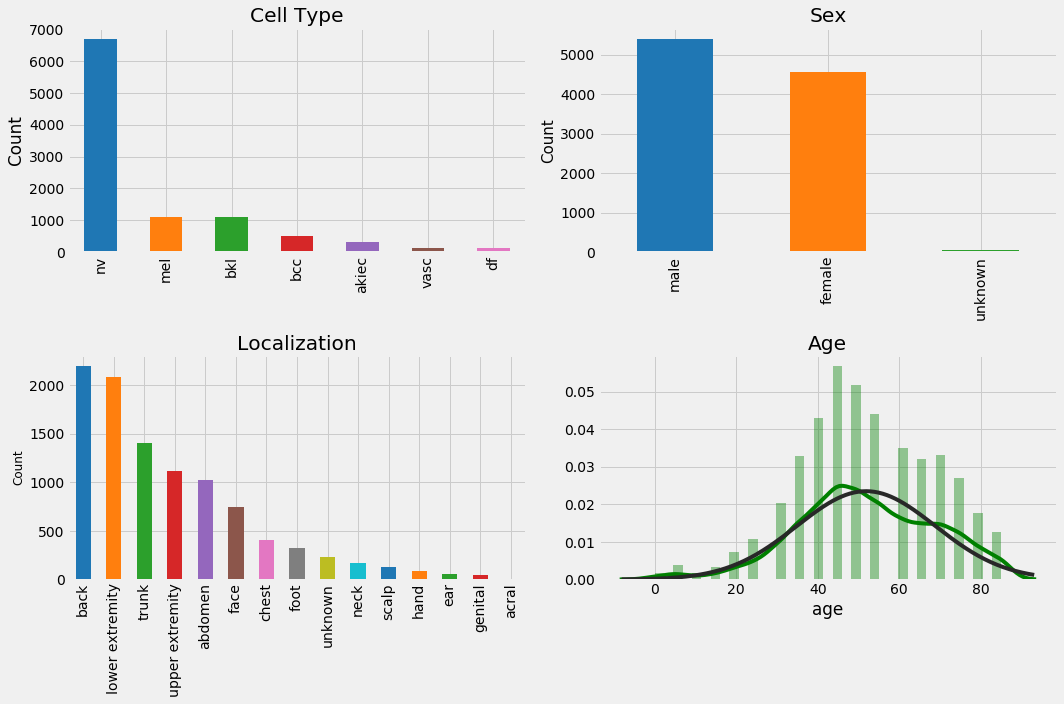

In [36]:
fig = plt.figure(figsize=(15,10))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

ax1 = fig.add_subplot(221)
metadata['dx'].value_counts().plot(kind='bar', ax=ax1, color=colors)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
metadata['sex'].value_counts().plot(kind='bar', ax=ax2, color=colors)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
metadata['localization'].value_counts().plot(kind='bar', color=colors)
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')


ax4 = fig.add_subplot(224)
sample_age = metadata[pd.notnull(metadata['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='green');
ax4.set_title('Age')

plt.tight_layout()
plt.show()